## Proyecto Final Nizar Karim Uribe Orihuela

Diplomado en Inteligencia Artificial

En este Jupyter notebook se realiza el entrenamiento de una red neuronal utilizando únicamente las bandas (2,3 y 4) correspondientes al espectro visible RGB de la Plataforma Sentinel 2 que se pueden encontrar en la siguiente liga: kaggle.com/code/aniruddhmantrala/pv-facility-detection-v2/input

# Cambios para entrenamiento RGB
Se han modificado las celdas indicadas para que el dataset solo use las bandas 1, 2 y 3 (correspondientes a RGB) en lugar de las 10 bandas originales, ya que el dataset disponible no indica las longitudes de onda correspondientes a cada banda y manualmente se revisó cuáles correspondían al espectro visible RGB (~450nm-800nm).

### Resumen de modificaciones:
- Celda 3: Corte a primeras 3 bandas tras lectura con rasterio

In [14]:
#Se importa el dataset de entrenamiento y validación de Kaggle
import kagglehub
aniruddhmantrala_pv_facility_detection_path = kagglehub.dataset_download('aniruddhmantrala/pv-facility-detection')

print('Los datos han sido importados')


Los datos han sido importados


In [15]:
#Se importan las librerías requeridas para trabajar con álgebra lineal y data frames

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
         print(os.path.join(dirname, filename))


/kaggle/input/pv-facility-detection/images/6_tile_0_3.tif
/kaggle/input/pv-facility-detection/images/rot_17_tile_2_1.tif
/kaggle/input/pv-facility-detection/images/vertical_8_tile_1_0.tif
/kaggle/input/pv-facility-detection/images/vertical_6_tile_1_2.tif
/kaggle/input/pv-facility-detection/images/23_tile_1_0.tif
/kaggle/input/pv-facility-detection/images/vertical_23_tile_1_2.tif
/kaggle/input/pv-facility-detection/images/horizontal_18_tile_1_2.tif
/kaggle/input/pv-facility-detection/images/vertical_21_tile_0_1.tif
/kaggle/input/pv-facility-detection/images/horizontal_11_tile_2_1.tif
/kaggle/input/pv-facility-detection/images/horizontal_30_tile_0_2.tif
/kaggle/input/pv-facility-detection/images/rot_4_tile_1_0.tif
/kaggle/input/pv-facility-detection/images/horizontal_29_tile_0_1.tif
/kaggle/input/pv-facility-detection/images/vertical_11_tile_1_0.tif
/kaggle/input/pv-facility-detection/images/vertical_28_tile_3_0.tif
/kaggle/input/pv-facility-detection/images/rot_7_tile_2_1.tif
/kaggle/in

In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.0 MB/s eta 0:00:00


In [5]:
#Se importan las librerías necesarias para trabajar con PyTorch y con archivos
#raster que en este caso son las imágenes satelitales de Sentinel 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF

import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import rasterio

from glob import glob
import zipfile
import shutil

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

from torch.utils.data import DataLoader

#En las próximas celdas se define el modelo

In [6]:
class MSDPath(nn.Module):
    def __init__(self, batch_size):
        super(MSDPath, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Conv3d(1, 32, kernel_size=5, stride=1, padding=2))

        self.encoder.append(nn.Sequential(
            (nn.MaxPool3d(kernel_size=(2,2,1), stride=2)),
            (nn.Conv3d(32, 64, kernel_size=5, stride=1, padding=2))))

        self.encoder.append(nn.Sequential(
            (nn.MaxPool3d(kernel_size=(2,2,1), stride=2)),
            (nn.Conv3d(64, 128, kernel_size=5, stride=1, padding=2))))

        self.conv2 = nn.Conv2d(320, 16, kernel_size=1, stride=1)
        self.conv4 = nn.Conv2d(320, 32, kernel_size=1, stride=1)
        self.conv6 = nn.Conv2d(384, 64, kernel_size=1, stride=1)

    def forward(self, x):
        skips = []
        x = x.reshape(self.batch_size, 1, 256, 256, 10)
        conv1 = self.encoder[0](x)
        conv3 = self.encoder[1](conv1)
        conv5 = self.encoder[2](conv3)


        r1 = conv1.view((self.batch_size, 320, 256, 256))
        r2 = conv3.view((self.batch_size, 320, 128, 128))
        r3 = conv5.view((self.batch_size, 384, 64, 64))

        r1 = self.conv2(r1)
        r2 = self.conv4(r2)
        r3 = self.conv6(r3)

        skips.append(r3)
        skips.append(r2)
        skips.append(r1)

        return skips


class MSPBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MSPBlock, self).__init__()

        # Pooling layers
        self.pool1 = torch.nn.AdaptiveAvgPool2d((32, 32))
        self.pool2 = torch.nn.AdaptiveAvgPool2d((16, 16))
        self.pool3 = torch.nn.AdaptiveAvgPool2d((8, 8))
        self.pool4 = torch.nn.AdaptiveAvgPool2d((4, 4))

        # 1x1 convolution layers
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels // 16, kernel_size=1, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(in_channels, out_channels // 8, kernel_size=1, stride=1, padding=0)
        self.conv3 = torch.nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0)
        self.conv4 = torch.nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, stride=1, padding=0)

        # Up-sampling layers with corrected scale factors
        self.up1 = torch.nn.Upsample(scale_factor=(1, 1), mode='bilinear')
        self.up2 = torch.nn.Upsample(scale_factor=(2, 2), mode='bilinear')
        self.up3 = torch.nn.Upsample(scale_factor=(4, 4), mode='bilinear')
        self.up4 = torch.nn.Upsample(scale_factor=(8, 8), mode='bilinear')

    def forward(self, x):
        # Pooling
        pool1 = self.pool1(x)
        pool2 = self.pool2(x)
        pool3 = self.pool3(x)
        pool4 = self.pool4(x)

        # 1x1 convolution
        conv1 = self.conv1(pool1)
        conv2 = self.conv2(pool2)
        conv3 = self.conv3(pool3)
        conv4 = self.conv4(pool4)

        # Up-sampling
        up1 = self.up1(conv1)
        up2 = self.up2(conv2)
        up3 = self.up3(conv3)
        up4 = self.up4(conv4)

        # Concatenate
        output = torch.cat([x, up1, up2, up3, up4], dim=1)

        return output


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)



class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=10, out_channels=1, features=[64, 128, 256], device="cpu", batch_size=16):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=1, stride=2)

        # Down part

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # UP part

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(
                feature * 2, feature, kernel_size=2, stride=2
            ))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for index in range(0, len(self.ups), 2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index // 2]

            # Resize x to match the shape of skip_connection
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[index + 1](concat_skip)

        return self.final_conv(x)


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms



class PVDetectionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, output_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.output_size = output_size
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read().astype('float32')
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        image = image[:3, :, :]  # <-- aquí corregimos el nombre de la variable

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return torch.from_numpy(image), torch.tensor(label)


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        with rasterio.open(image_path) as src:
            image = src.read()
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        imgage = image[:3, :, :]  # extrae canales 0,1,2
        mask = Image.open(mask_path)

        image = torch.tensor(image).permute(1,2,0).numpy()

        mask = mask.resize(self.output_size)
        mask_transform = transforms.Grayscale(1)
        mask = mask_transform(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
from torch.utils.data import DataLoader
import shutil


def save_checkpoint(state, filename="my_checkpoint_rgb.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading Checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def get_loaders(batch_size, train_ratio, val_ratio, test_ratio):
    # Create a single dataset for all images in the folder
    image_folder = "/kaggle/input/pv-facility-detection/images"
    masks_folder = "/kaggle/input/pv-facility-detection/masks"
    test_image_folder = "/kaggle/input/pv-facility-detection/test_images"
    test_masks_folder = "/kaggle/input/pv-facility-detection/test_masks"

    seed = 42
    torch.manual_seed(seed)

    # Create the custom dataset using all images and annotations
    dataset = PVDetectionDataset(image_folder, masks_folder, transform=transform)
    final_test_dataset = PVDetectionDataset(test_image_folder, test_masks_folder, transform=transform)

    # Split the dataset into train, validation, and test sets if needed
    # Example of splitting into train, val, and test (adjust the split ratios):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset)) - 8
    test_size = int(test_ratio * len(dataset)) + 8
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders for training, validation, and testing
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    final_test_data_loader = torch.utils.data.DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)
    print(train_size, val_size, test_size)
    return train_data_loader, val_data_loader, test_data_loader, final_test_data_loader


def validate_and_check_accuracy(loader, model, loss_fn, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    total_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()  # Apply threshold for binary prediction
            val_loss = loss_fn(preds, y)
            total_loss += val_loss.item()

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(y)

            # Calculate Dice score
            intersection = (preds * y).sum().item()
            union = preds.sum().item() + y.sum().item()
            dice_score += (2 * intersection) / (union + 1e-8)

    accuracy = (num_correct / num_pixels) * 100
    dice_score /= len(loader)
    average_loss = total_loss / len(loader)

    print(f"Got {num_correct}/{num_pixels} correct.")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Dice Score: {dice_score:.4f}")
    print("Validation Loss: {:.4f}".format(average_loss))

    model.train()

    return average_loss


def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Remove the folder and its contents
    os.makedirs(folder, exist_ok=True)  # Recreate the output folder

    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        # Save images
        red_band = x[:, 2, :, :]
        green_band = x[:, 1, :, :]
        blue_band = x[:, 0, :, :]
        rgb_image = torch.stack([red_band, green_band, blue_band], dim=1)

        rgb_image = rgb_image.view(16, 3, 256, 256)
        torchvision.utils.save_image(rgb_image, f"{folder}/image_{idx}.png")
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y, f"{folder}/{idx}.png")

    model.train()


# Usage example:
# save_predictions_as_imgs(loader, model, folder="output_folder", device="cuda")


# Usage example:
# save_predictions_as_imgs(loader, model, folder="output_folder", device="cuda")

In [9]:
def test_model(test_loader, model, device="cuda"):
    model.eval()  #
    total_correct = 0
    num_pixels = 0
    criterion = nn.BCEWithLogitsLoss()

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = torch.sigmoid(model(inputs))

            # Calculate binary predictions (assuming a threshold of 0.5)
            preds = (outputs > 0.5).float()
            num_pixels += torch.numel(targets)

            TP += ((preds == 1) & (targets == 1)).sum().item()
            TN += ((preds == 0) & (targets == 0)).sum().item()
            FP += ((preds == 1) & (targets == 0)).sum().item()
            FN += ((preds == 0) & (targets == 1)).sum().item()

            # You can also calculate Accuracy, Precision, Recall, and F1-score using these values:
        accuracy = (TP + TN) / num_pixels
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
        mcc = (TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5 if ((TP + FP) * (TP + FN) * (
                    TN + FP) * (TN + FN)) != 0 else 0.0

        # Calculate Kappa Coefficient
        total_agreement = (TP + TN) / num_pixels
        expected_agreement = ((TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)) / (num_pixels * num_pixels)
        kappa = (total_agreement - expected_agreement) / (1 - expected_agreement) if (
                                                                                                 1 - expected_agreement) != 0 else 0.0

        # Se imprimen en pantalla las métricas de evaluación
        print()
        print("--------------------------------------")
        print("Evaluation Metrics\n")
        print(f"True Positives (TP): {TP}")
        print(f"True Negatives (TN): {TN}")
        print(f"False Positives (FP): {FP}")
        print(f"False Negatives (FN): {FN}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1_score}")
        print(f"Matthews Correlation Coefficient (MCC): {mcc}")
        print(f"Kappa Coefficient: {kappa}")

    # Se muestran las métricas de evaluación del modelo
    return accuracy, precision, recall, f1_score, mcc, kappa

In [10]:
class PVDetectionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, output_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.output_size = output_size
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read().astype('float32')
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        image = image[:3, :, :]

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return torch.from_numpy(image), torch.tensor(label)


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        with rasterio.open(image_path) as src:
            image = src.read()
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        image = image[:3, :, :]  # extrae canales 0,1,2
        mask = Image.open(mask_path)
        mask = mask.resize(self.output_size)
        mask_transform = transforms.Grayscale(1)
        mask = mask_transform(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [11]:
class PVDetectionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, output_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.output_size = output_size
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        self.mask_files = os.listdir(mask_dir)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read().astype('float32')
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        image = image[:3, :, :]  # <-- aquí corregimos el nombre de la variable

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return torch.from_numpy(image), torch.tensor(label)


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        with rasterio.open(image_path) as src:
            image = src.read()
        # --- Cambio: seleccionar solo bandas 1,2 y 3 (RGB) ---
        image = image[:3, :, :]  # extrae canales 0,1,2 #Fixed: changed 'imgage' to 'image'
        mask = Image.open(mask_path)

        # Fix: Permute the dimensions to (channels, height, width)
        image = torch.tensor(image).permute(1, 2, 0).numpy()

        mask = mask.resize(self.output_size)
        mask_transform = transforms.Grayscale(1)
        mask = mask_transform(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

#En la siguiente celda se realiza el entrenamiento

In [45]:
#Aquí se realiza el entrenamiento

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


# HYPERPARAMETROS
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 2
# NUM_WORKERS = 8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
TRAIN_RATIO = 0.75
VAL_RATIO = 0.125
TEST_RATIO = 0.125
# PIN_MEMORY = True
LOAD_MODEL = False
CLIP_VALUE = 5


def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    total_loss = 0.0

    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        optimizer.zero_grad()

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # update from tqdm
        loop.set_postfix(loss=loss.item())

    average_loss = total_loss / len(loader)
    print(f"Training Loss: {average_loss:.4f}")


model = UNET(in_channels=3, out_channels=1, device=DEVICE, batch_size=BATCH_SIZE).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,  # Reduce LR by half when the metric plateaus
    patience=2,  # Number of epochs with no improvement after which LR will be reduced
    verbose=True,  # Se imprimen las actualizaciones del LR
    min_lr=1e-8  # Minimum LR (optional)
)

# Define early stopping parameters
early_stopping_patience = 8 # Number of epochs with no improvement after which to stop training
best_val_loss = float('inf')  # Initialize with a large value

train_loader, val_loader, test_loader, final_test_loader = get_loaders(
    BATCH_SIZE,
    TRAIN_RATIO,
    VAL_RATIO,
    TEST_RATIO
)

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint_rgb.pth.tar"), model)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("--------------------------------------")
    train_fn(train_loader, model, optimizer, loss_fn)

    val_loss = validate_and_check_accuracy(val_loader, model, loss_fn, device=DEVICE)

    scheduler.step(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter when there's improvement
        best_model = model
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= early_stopping_patience:
        print(f"Validation loss has not improved for {early_stopping_patience} epochs. Stopping early.")
        break

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }


    save_checkpoint(checkpoint)

#     print some examples to a folder
    save_predictions_as_imgs(
        val_loader, best_model, folder="saved_images", device=DEVICE
    )

save_predictions_as_imgs(
    test_loader, best_model, folder="test_images", device=DEVICE
)



test_accuracy, precision, recall, f1_score, mcc, kappa = test_model(test_loader, best_model, device="cuda")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1392 224 240
Epoch 1/2
--------------------------------------


  0%|          | 0/87 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 87/87 [01:11<00:00,  1.22it/s, loss=0.313]


Training Loss: 0.4006
Got 12921210/14680064 correct.
Accuracy: 88.02%
Dice Score: 0.5463
Validation Loss: 0.6872
=> Saving checkpoint
Epoch 2/2
--------------------------------------


100%|██████████| 87/87 [01:10<00:00,  1.23it/s, loss=0.392]


Training Loss: 0.3081
Got 12950552/14680064 correct.
Accuracy: 88.22%
Dice Score: 0.5410
Validation Loss: 0.6848
=> Saving checkpoint


Testing: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


--------------------------------------
Evaluation Metrics

True Positives (TP): 1325782
True Negatives (TN): 12813917
False Positives (FP): 329838
False Negatives (FN): 1101114
Accuracy: 0.8989778518676758
Precision: 0.8007767482876506
Recall: 0.546287109130346
F1 Score: 0.6494926168078705
Matthews Correlation Coefficient (MCC): 0.6132831161028567
Kappa Coefficient: 0.5867494494590474


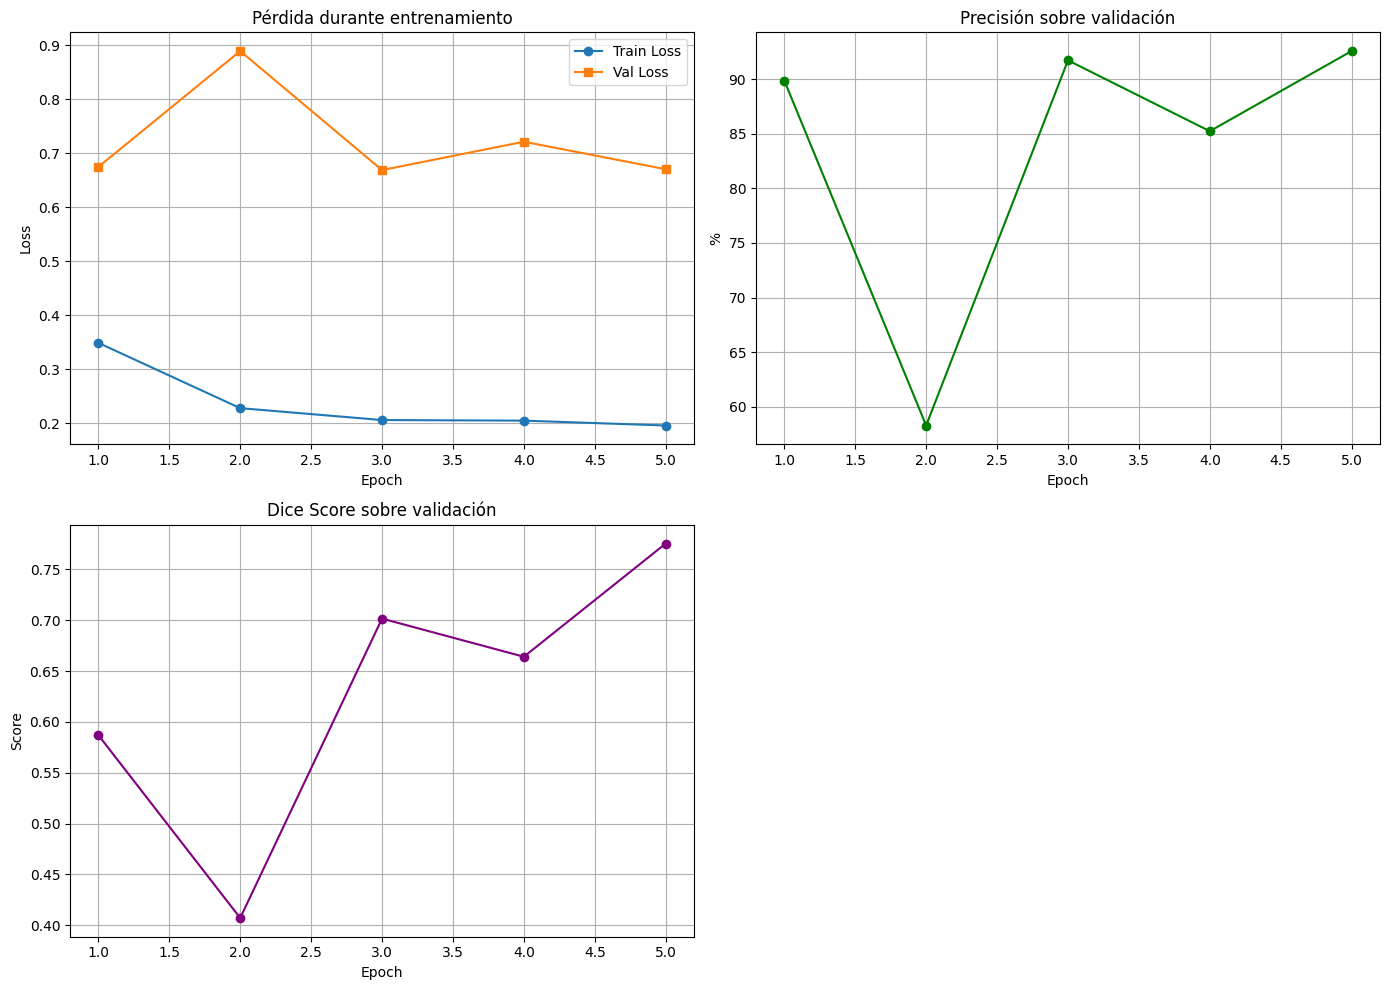

In [18]:
# ---------------------- GRAFICAS DE METRICAS DEL ENTRENAMIENTO ----------------------
import matplotlib.pyplot as plt
# Resultados por época tras reentrenamiento reciente
train_losses = [0.3491, 0.2283, 0.2063, 0.2052, 0.1962]
val_losses =   [0.6748, 0.8892, 0.6689, 0.7214, 0.6705]
accuracies =   [89.87, 58.28, 91.73, 85.24, 92.58]
dice_scores =  [0.5870, 0.4072, 0.7016, 0.6641, 0.7754]
epochs = list(range(1, len(train_losses) + 1))

train_losses = [0.3491, 0.2283, 0.2063, 0.2052, 0.1962]
val_losses = [0.6748, 0.8892, 0.6689, 0.7214, 0.6705]
accuracies = [89.87, 58.28, 91.73, 85.24, 92.58]
dice_scores = [0.5870, 0.4072, 0.7016, 0.6641, 0.7754]
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante entrenamiento")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, accuracies, label="Accuracy", color="green", marker="o")
plt.xlabel("Epoch")
plt.ylabel("%")
plt.title("Precisión sobre validación")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, dice_scores, label="Dice Score", color="purple", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Dice Score sobre validación")
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
test_accuracy, precision, recall, f1_score, mcc, kappa = test_model(test_loader, best_model, device="cuda")

Testing: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


--------------------------------------
Evaluation Metrics

True Positives (TP): 1325782
True Negatives (TN): 12813917
False Positives (FP): 329838
False Negatives (FN): 1101114
Accuracy: 0.8989778518676758
Precision: 0.8007767482876506
Recall: 0.546287109130346
F1 Score: 0.6494926168078705
Matthews Correlation Coefficient (MCC): 0.6132831161028567
Kappa Coefficient: 0.5867494494590474


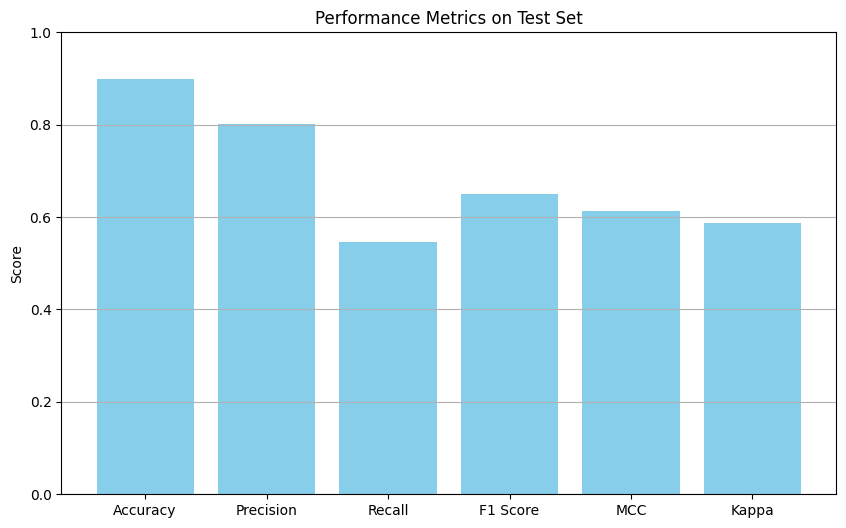

In [47]:
import matplotlib.pyplot as plt

metrics = {
    "Accuracy": test_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score,
    "MCC": mcc,
    "Kappa": kappa
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Performance Metrics on Test Set")
plt.grid(axis='y')
plt.show()

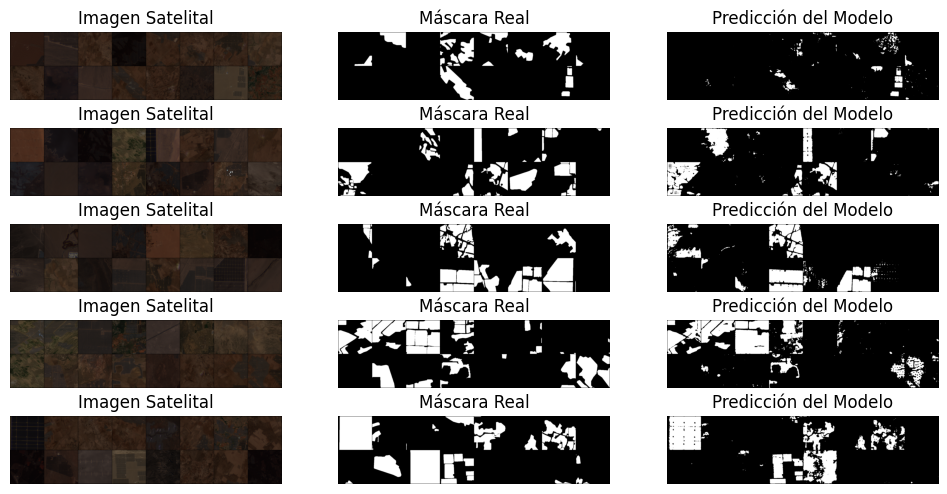

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
import glob

def display_prediction_examples(folder_path="test_images", num_examples=5):
    pred_files = sorted(glob.glob(os.path.join(folder_path, "pred_*.png")))
    gt_files = sorted(glob.glob(os.path.join(folder_path, "[0-9]*.png")))
    img_files = sorted(glob.glob(os.path.join(folder_path, "image_*.png")))

    plt.figure(figsize=(10, num_examples * 1))
    for i in range(min(num_examples, len(pred_files))):
        # Cargar imágenes
        img = Image.open(img_files[i])
        pred = Image.open(pred_files[i])
        gt = Image.open(gt_files[i])

        # Mostrar imágenes
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Imagen Satelital")
        plt.axis("off")

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(gt, cmap='gray')
        plt.title("Máscara Real")
        plt.axis("off")

        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicción del Modelo")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Mostrar ejemplos visuales
display_prediction_examples("test_images", num_examples=5)


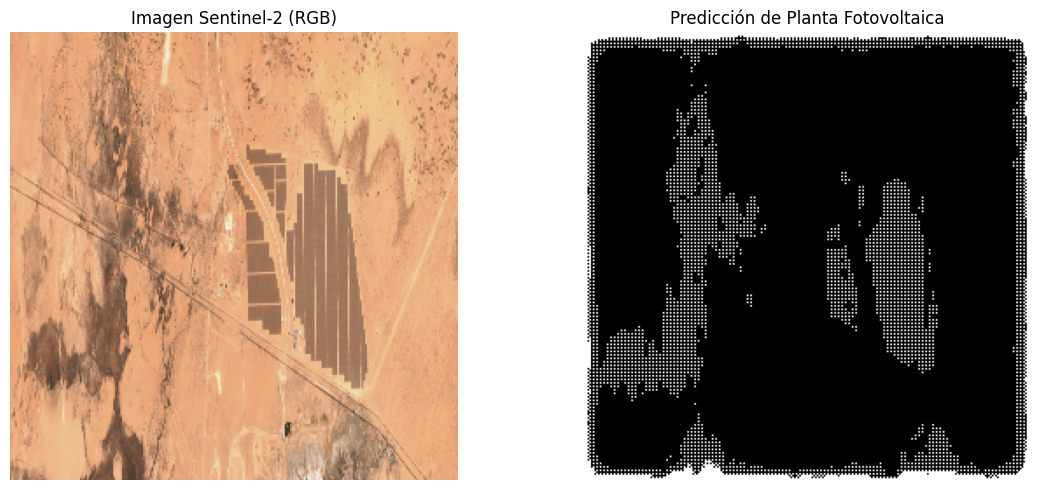

In [80]:
import rasterio
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuración
tif_path = "/content/2025-04-21-00_00_2025-04-21-23_59_Sentinel-2_L2A_True_color.tiff" #"/content/2025-04-15-00_00_2025-04-15-23_59_Sentinel-2_L2A_True_color.tiff"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Cargar imagen TIFF con rasterio
with rasterio.open(tif_path) as src:
    image = src.read()  # (bands, height, width)

# 2. Verificar dimensiones y normalizar [0-1]
image = image.astype(np.float32)

# Fix: Ensure band order is R:1, G:2, B:3
# Assuming the original band order is BGR, swap channels
# Adjust this if your TIFF file has a different band order
# For Sentinel-2 data, the band order is typically B, G, R, NIR, ...
# So we select bands 2, 1, 0 to get R, G, B
image = image[[0, 1, 2], :, :]

# Fix: Apply normalization to match training data
# Example: If training data was normalized by dividing by 8160
# image = image / 8160
# image = np.clip(image, 0, 1) # clip to 0-1

# For True color tiff, we typically divide by 255
image = image / 255.0 if image.max() > 1 else image

# 3. Recortar o redimensionar a 256x256
resize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # usa interpolación bilineal por defecto
])

# 4. Convertir a tensor con tamaño adecuado
image_tensor = torch.tensor(image).unsqueeze(0)  # (1, bands, H, W)
image_tensor = torch.nn.functional.interpolate(image_tensor, size=(256, 256), mode='bilinear')

# 5. Enviar a GPU/CPU
image_tensor = image_tensor.to(device)

# 6. Evaluar el modelo
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))
    pred = (pred > 0.000003).float().squeeze().cpu().numpy()

# 7. Mostrar resultado
plt.figure(figsize=(12, 5))

# Mostrar imagen RGB si hay suficientes bandas
rgb = image[:3]  # suponemos bandas [R,G,B] en [0,1]
rgb_resized = np.moveaxis(image_tensor[0, :3].cpu().numpy(), 0, -1)

plt.subplot(1, 2, 1)
plt.imshow(rgb_resized)
plt.title("Imagen Sentinel-2 (RGB)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicción de Planta Fotovoltaica")
plt.axis("off")

plt.tight_layout()
plt.show()

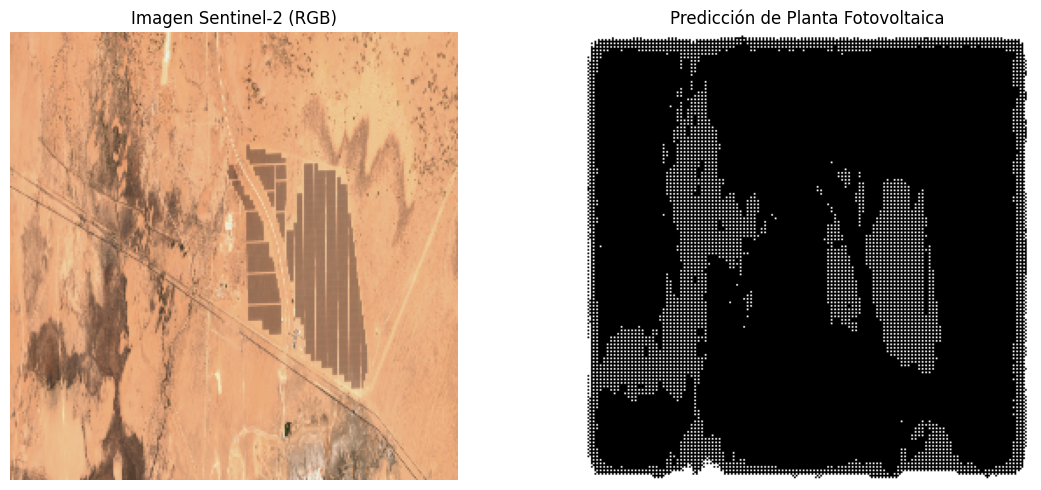

In [78]:
import rasterio
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuración
tif_path = "/content/2025-04-21-00_00_2025-04-21-23_59_Sentinel-2_L2A_True_color.tiff" #"/content/2025-04-15-00_00_2025-04-15-23_59_Sentinel-2_L2A_True_color.tiff"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Cargar imagen TIFF con rasterio
with rasterio.open(tif_path) as src:
    image = src.read()  # (bands, height, width)

# 2. Verificar dimensiones y normalizar [0-1]
image = image.astype(np.float32)

# Fix: Ensure band order is R:1, G:2, B:3
# Assuming the original band order is BGR, swap channels
# Adjust this if your TIFF file has a different band order
# For Sentinel-2 data, the band order is typically B, G, R, NIR, ...
# So we select bands 2, 1, 0 to get R, G, B
image = image[[0, 1, 2], :, :]

# Fix: Apply normalization to match training data
# Example: If training data was normalized by dividing by 8160
# image = image / 8160
# image = np.clip(image, 0, 1) # clip to 0-1

# For True color tiff, we typically divide by 255
image = image / 255.0 if image.max() > 1 else image

# 3. Recortar o redimensionar a 256x256
resize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # usa interpolación bilineal por defecto
])

# 4. Convertir a tensor con tamaño adecuado
image_tensor = torch.tensor(image).unsqueeze(0)  # (1, bands, H, W)
image_tensor = torch.nn.functional.interpolate(image_tensor, size=(256, 256), mode='bilinear')

# 5. Enviar a GPU/CPU
image_tensor = image_tensor.to(device)

# 6. Evaluar el modelo
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))
    pred = (pred > 0.000002).float().squeeze().cpu().numpy()

# 7. Mostrar resultado
plt.figure(figsize=(12, 5))

# Mostrar imagen RGB si hay suficientes bandas
rgb = image[:3]  # suponemos bandas [R,G,B] en [0,1]
rgb_resized = np.moveaxis(image_tensor[0, :3].cpu().numpy(), 0, -1)

plt.subplot(1, 2, 1)
plt.imshow(rgb_resized)
plt.title("Imagen Sentinel-2 (RGB)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicción de Planta Fotovoltaica")
plt.axis("off")

plt.tight_layout()
plt.show()

In [84]:
import rasterio
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ipywidgets import interact, Checkbox
import warnings
from rasterio.errors import NotGeoreferencedWarning

# --- Silenciar warning de georreferenciación ---
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Configuración
tif_path = "/content/2025-04-15-00_00_2025-04-15-23_59_Sentinel-2_L2A_True_color.tiff"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Cargar imagen TIFF con rasterio
with rasterio.open(tif_path) as src:
    image = src.read()  # shape = (bands, height, width)

# 2. Normalizar / seleccionar RGB
image = image.astype(np.float32)
image = image[[0, 1, 2], :, :]  # quedarse con bandas 1,2,3 (RGB)
image = image / 255.0 if image.max() > 1 else image

# 3. Redimensionar a 256×256 y convertir a tensor
resize = transforms.Compose([
    transforms.ToTensor(),  # pasa a tensor (bands, H, W) y escala [0–1]
    transforms.Resize((256, 256))
])

# Fix: Permute the dimensions before applying transforms
image = image.transpose(1, 2, 0)  # Change to (height, width, channels)

image_tensor = resize(image)  # (3,256,256)
image_tensor = image_tensor.unsqueeze(0).to(device)  # (1,3,256,256)

# 4. Inferencia
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))  # (1,1,256,256) ó (1,256,256)
    pred = (pred > 0.01).float().cpu().squeeze().numpy()  # (256,256) binaria

# 5. Preparar RGB para plotting
rgb_resized = np.moveaxis(image_tensor[0, :3].cpu().numpy(), 0, -1)  # (256,256,3)

# 6. Function to display overlay (using pred as mask)
H, W, _ = rgb_resized.shape

def mostrar_overlay(alpha=0.4):  # Adjust alpha for overlay transparency
    """Displays the overlay using the prediction as a mask."""
    overlay = np.zeros((H, W, 3), dtype=np.float32)
    overlay[pred == 1] = [0, 1, 0]  # Green for predicted PV areas

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_resized)
    plt.imshow(overlay, alpha=alpha)  # Apply overlay with transparency
    plt.axis("off")
    plt.title("Predicted PV Areas (Green)")
    plt.show()

# Use interact to control overlay transparency
interact(mostrar_overlay, alpha=(0.0, 1.0, 0.1))  # Slider for alpha

interactive(children=(FloatSlider(value=0.4, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.mostrar_overlay(alpha=0.4)>

Text(0.5, 1.0, 'Imagen sin predicciones para comparar)')

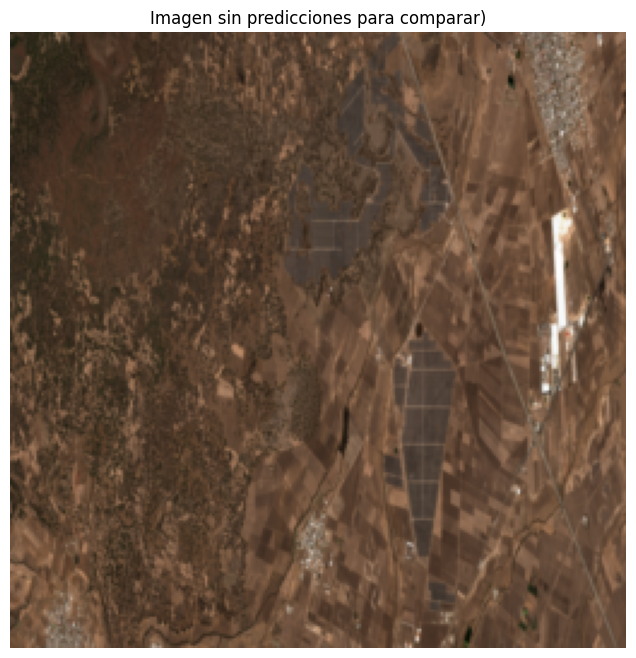

In [83]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb_resized)
plt.axis("off")
plt.title("Imagen sin predicciones para comparar)")

#Intentamos mejorar nuestras predicciones

In [43]:
import rasterio
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ipywidgets import interact, Checkbox
import warnings
from rasterio.errors import NotGeoreferencedWarning

# --- Silenciar warning de georreferenciación ---
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Configuración
tif_path = "/content/2025-04-21-00_00_2025-04-21-23_59_Sentinel-2_L2A_True_color.jpg"#"/content/2025-04-15-00_00_2025-04-15-23_59_Sentinel-2_L2A_True_color.tiff"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Cargar imagen TIFF con rasterio
with rasterio.open(tif_path) as src:
    image = src.read()  # shape = (bands, height, width)

# 2. Normalizar / seleccionar RGB
image = image.astype(np.float32)
image = image[[0, 1, 2], :, :]  # quedarse con bandas 1,2,3 (RGB)
image = image / 255.0 if image.max() > 1 else image

# 3. Redimensionar a 256×256 y convertir a tensor
resize = transforms.Compose([
    transforms.ToTensor(),  # pasa a tensor (bands, H, W) y escala [0–1]
    transforms.Resize((256, 256))
])

# Fix: Permute the dimensions before applying transforms
image = image.transpose(1, 2, 0)  # Change to (height, width, channels)

image_tensor = resize(image)  # (3,256,256)
image_tensor = image_tensor.unsqueeze(0).to(device)  # (1,3,256,256)

# 4. Inferencia
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))  # (1,1,256,256) ó (1,256,256)
    pred = (pred > 0.35).float().cpu().squeeze().numpy()  # (256,256) binaria

# 5. Preparar RGB para plotting
rgb_resized = np.moveaxis(image_tensor[0, :3].cpu().numpy(), 0, -1)  # (256,256,3)

# 6. Function to display overlay (using pred as mask)
H, W, _ = rgb_resized.shape

def mostrar_overlay(alpha=0.4):  # Adjust alpha for overlay transparency
    """Displays the overlay using the prediction as a mask."""
    overlay = np.zeros((H, W, 3), dtype=np.float32)
    overlay[pred == 1] = [0, 1, 0]  # Green for predicted PV areas

    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_resized)
    plt.imshow(overlay, alpha=alpha)  # Apply overlay with transparency
    plt.axis("off")
    plt.title("Predicted PV Areas (Green)")
    plt.show()

# Use interact to control overlay transparency
interact(mostrar_overlay, alpha=(0.0, 1.0, 0.1))  # Slider for alpha

interactive(children=(FloatSlider(value=0.4, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.mostrar_overlay(alpha=0.4)>

In [45]:
import rasterio
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ipywidgets import interact, Checkbox
import warnings
from rasterio.errors import NotGeoreferencedWarning

# --- Silenciar warning de georreferenciación ---
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Configuración
tif_path = "/content/2025-04-21-00_00_2025-04-21-23_59_Sentinel-2_L2A_True_color.tiff"#"/content/2025-04-15-00_00_2025-04-15-23_59_Sentinel-2_L2A_True_color.tiff"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Cargar imagen TIFF con rasterio
with rasterio.open(tif_path) as src:
    image = src.read()  # shape = (bands, height, width)

# 2. Normalizar / seleccionar RGB
image = image.astype(np.float32)
image = image[[0, 1, 2], :, :]  # quedarse con bandas 1,2,3 (RGB)
image = image / 255.0 if image.max() > 1 else image

# 3. Redimensionar a 256×256 y convertir a tensor
resize = transforms.Compose([
    transforms.ToTensor(),  # pasa a tensor (bands, H, W) y escala [0–1]
    transforms.Resize((256, 256))
])

# Fix: Permute the dimensions before applying transforms
image = image.transpose(1, 2, 0)  # Change to (height, width, channels)

image_tensor = resize(image)  # (3,256,256)
image_tensor = image_tensor.unsqueeze(0).to(device)  # (1,3,256,256)

# 4. Inferencia
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(image_tensor))  # (1,1,256,256) ó (1,256,256)
    pred = (pred > 0.35).float().cpu().squeeze().numpy()  # (256,256) binaria

# 5. Preparar RGB para plotting
rgb_resized = np.moveaxis(image_tensor[0, :3].cpu().numpy(), 0, -1)  # (256,256,3)

# 6. Function to display overlay (using pred as mask)
H, W, _ = rgb_resized.shape

def mostrar_overlay(alpha=0.4):  # Adjust alpha for overlay transparency
    """Displays the overlay using the prediction as a mask."""
    overlay = np.zeros((H, W, 3), dtype=np.float32)
    overlay[pred == 1] = [0, 1, 0]  # Green for predicted PV areas

    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_resized)
    plt.imshow(overlay, alpha=alpha)  # Apply overlay with transparency
    plt.axis("off")
    plt.title("Predicted PV Areas (Green)")
    plt.show()

# Use interact to control overlay transparency
interact(mostrar_overlay, alpha=(0.0, 1.0, 0.1))  # Slider for alpha

interactive(children=(FloatSlider(value=0.4, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.mostrar_overlay(alpha=0.4)>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torch.cuda.empty_cache()

# Conclusiones

El modelo requiere una cantidad considerable de imágenes para alcanzar un entrenamiento verdaderamente efectivo. En este estudio de caso, se logró detectar exitosamente plantas fotovoltaicas en diversas imágenes provenientes de fuentes externas a los conjuntos originales de entrenamiento y validación, lo que evidencia la capacidad del modelo para generalizar sobre datos no vistos previamente. No obstante, también se observaron numerosos falsos positivos, lo cual resalta la necesidad de continuar con el refinamiento del modelo y la ampliación del conjunto de datos.

A pesar de estas limitaciones iniciales, esta primera aproximación ha demostrado ser una herramienta valiosa para la identificación de instalaciones fotovoltaicas. Los resultados son alentadores y permiten vislumbrar un alto potencial para la aplicación de esta metodología a gran escala, especialmente en proyectos de mapeo y monitoreo continuo en el futuro.